# Basic regression: Benzinpreis vorhersagen

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [5]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mean_absolute_error

2.3.0


## Dateset

### Daten herunterladen und in ein Dataframe speichern

In [6]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [7]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Daten säubern

Zeilen mit leeren Felder löschen.

In [8]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [9]:
dataset = dataset.dropna()

Die `"Origin"` Spalte ist eigentlich categorical und nicht Numerisch. Dies müssen wir umbauen.


In [10]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [11]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Aufteilen der Daten in Train und Test
Nun teilen wir den Datensatz in einen Trainingssatz und einen Testsatz auf.

Wir werden den Testsatz bei der Endauswertung unserer Modelle verwenden.

In [12]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Features von Labels trennen

Trennen Sie den Zielwert, das "Label", von den Features. Dieses Label ist der Wert, auf dessen Vorhersage Sie das Modell trainieren werden.

In [15]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Normalisierung

In der Statistiktabelle ist leicht zu erkennen, wie unterschiedlich die Bereiche der einzelnen Features sind.

In [16]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


Es ist eine gute Praxis, Features zu normalisieren, die unterschiedliche Skalierungen und Bereiche verwenden. 

Dies ist unter anderem deshalb wichtig, weil die Features mit den Gewichten der Modelle multipliziert werden. Die Skala der Ausgänge und die Skala der Gradienten werden also durch die Skala der Eingänge beeinflusst. 

Obwohl ein Modell ohne Feature-Normalisierung *möglicherweise* konvergiert, macht die Normalisierung das Training viel stabiler. 

### Der Normalization Layer
Der Layer `preprocessing.Normalization` ist eine saubere und einfache Möglichkeit, diese Vorverarbeitung in Ihr Modell einzubauen.

Der erste Schritt ist die Erstellung des Layers: 

In [17]:
normalizer = preprocessing.Normalization()

Nun passen wir es den Daten mit `.adapt()` an:

In [18]:
normalizer.adapt(np.array(train_features))

Das berechnet für jedes Feature (Spalte) das mean und variance, welches dann im Layer gespeichert wird. 

In [19]:
print(normalizer.mean.numpy())

[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]


When the layer is called it returns the input data, with each feature independently normalized:

In [20]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Linear regression

### Eine Variable


Das Training eines Modells mit `tf.keras` beginnt typischerweise mit der Definition der Modellarchitektur.

In diesem Fall verwenden Sie ein Sequentielles Modell. Dieses Modell stellt eine Abfolge von Schritten dar. In diesem Fall gibt es zwei Schritte:

* Normalisierung der eingegebenen `horsepower`.
* Wenden Sie eine lineare Transformation ($y = mx+b$) an, um 1 Ausgabe unter Verwendung von `layers.Dense` zu erzeugen.

Zuerst den horsepower `Normalization` layer:

In [21]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=horsepower.shape)
horsepower_normalizer.adapt(horsepower)

Model bauen:

In [22]:
horsepower_model = tf.keras.Sequential()
horsepower_model.add(horsepower_normalizer)
horsepower_model.add(Dense(units=1))

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Dieses Modell wird `MPG` aus `Horsepower` vorhersagen.

Lassen Sie das untrainierte Modell mit den ersten 10 Pferdestärkenwerten laufen. Das Ergebnis wird nicht gut sein, aber Sie werden sehen, dass es die erwartete Form `(10,1)` hat:

In [23]:
horsepower_model.predict(horsepower[:10])

array([[ 0.252],
       [ 0.142],
       [-0.465],
       [ 0.353],
       [ 0.319],
       [ 0.125],
       [ 0.378],
       [ 0.319],
       [ 0.083],
       [ 0.142]], dtype=float32)

In [24]:
opt_adam = Adam(learning_rate=0.1)
horsepower_model.compile(
    optimizer=opt_adam,
    loss=mean_absolute_error)

Sobald das Training konfiguriert ist, verwenden Sie Model.fit(), um das Training auszuführen:

In [25]:
history = horsepower_model.fit(
    train_features['Horsepower'], 
    train_labels,
    epochs=100,
    validation_split = 0.2)

CPU times: user 3.87 s, sys: 893 ms, total: 4.76 s
Wall time: 2.97 s


Wie ist das Training verlaufen?

In [27]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

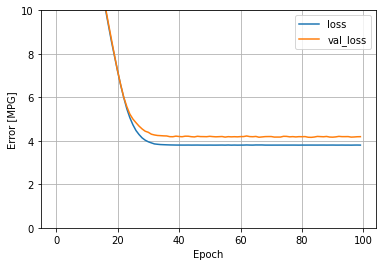

In [28]:
plot_loss(history)

Da es sich um eine Regression mit einer einzigen Variable handelt, ist es einfach, die Vorhersagen des Modells als Funktion des Inputs zu betrachten:

In [30]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [31]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

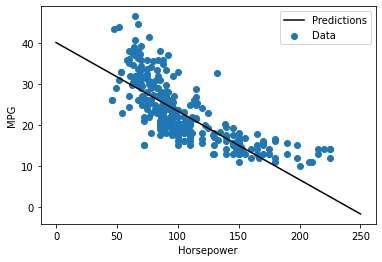

In [32]:
plot_horsepower(x,y)